In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import psycopg2
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

In [2]:
def get_connection():
    return psycopg2.connect(
        host='localhost',
        port=5432,
        database='city_marketing',
        user='postgres',
        password='1234'
    )

In [3]:
conn = get_connection()
pedestrian_data = pd.read_sql("SELECT * FROM pedestrian_zones", conn)
conn.close()

print(f"Loaded {len(pedestrian_data)} pedestrian zone records")

Loaded 626 pedestrian zone records


In [4]:
print("Dataset shape:", pedestrian_data.shape)
print("\nColumn info:")
pedestrian_data.info()

Dataset shape: (626, 6)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zone_name            626 non-null    object 
 1   arrondissement       626 non-null    object 
 2   date_partition_bovp  626 non-null    object 
 3   longitude            626 non-null    float64
 4   latitude             626 non-null    float64
 5   geo_shape            626 non-null    object 
dtypes: float64(2), object(4)
memory usage: 29.5+ KB


In [5]:
pedestrian_data['is_named'] = pedestrian_data['zone_name'] != '0'

named_zones = pedestrian_data[pedestrian_data['is_named']]
unnamed_zones = pedestrian_data[~pedestrian_data['is_named']]

print(f"Zone analysis:")
print(f"Total zones: {len(pedestrian_data)}")
print(f"Named zones: {len(named_zones)}")
print(f"Unnamed zones: {len(unnamed_zones)}")

if len(named_zones) > 0:
    print(f"\nSample named zones:")
    unique_named = named_zones['zone_name'].unique()
    for name in unique_named[:10]:
        print(f"  {name}")
    print(f"\nTotal unique named zones: {len(unique_named)}")

Zone analysis:
Total zones: 626
Named zones: 323
Unnamed zones: 303

Sample named zones:
  
  Rue Vivian Maier
  zone Père Lachaise
  Passage Championnet
  Rue Charles Bertheau et Jean Dunand
  Montorgueil-Saint-Denis
  Rue Richomme
  Rue du Père Brottier et avenue Boudon
  Rue des Boulangers
  Rue du Père Guérin

Total unique named zones: 250


In [6]:
pedestrian_data['arrondissement_clean'] = pedestrian_data['arrondissement'].astype(str).str.strip()

arr_distribution = pedestrian_data['arrondissement_clean'].value_counts().reset_index()
arr_distribution.columns = ['arrondissement', 'zone_count']
arr_distribution = arr_distribution.sort_values('arrondissement')

print("Zones by arrondissement:")
print(arr_distribution.to_string(index=False))

coverage_percentage = (len(arr_distribution) / 20) * 100
print(f"\nCoverage: {len(arr_distribution)}/20 arrondissements ({coverage_percentage:.1f}%)")
print(f"Average zones per arrondissement: {len(pedestrian_data)/len(arr_distribution):.1f}")

Zones by arrondissement:
arrondissement  zone_count
             1          26
            10          26
            11          31
            12          48
            13          59
            14          25
            15          30
            16          27
            17          26
            18          50
            19          56
             2          14
            20          66
             3          13
             4          33
             5          39
             6           9
             7          16
             8           8
             9          24

Coverage: 20/20 arrondissements (100.0%)
Average zones per arrondissement: 31.3


In [7]:
zone_analysis = pedestrian_data.groupby('arrondissement_clean').agg({
    'is_named': ['sum', 'count']
}).round(2)

zone_analysis.columns = ['named_zones', 'total_zones']
zone_analysis = zone_analysis.reset_index()
zone_analysis['unnamed_zones'] = zone_analysis['total_zones'] - zone_analysis['named_zones']
zone_analysis['named_percentage'] = (zone_analysis['named_zones'] / zone_analysis['total_zones'] * 100).round(1)

print("Zone quality by arrondissement:")
print(zone_analysis[['arrondissement_clean', 'total_zones', 'named_zones', 'unnamed_zones', 'named_percentage']].to_string(index=False))

# Commercial potential assessment
zone_analysis['commercial_potential'] = 'Low'
zone_analysis.loc[zone_analysis['named_percentage'] >= 70, 'commercial_potential'] = 'High'
zone_analysis.loc[(zone_analysis['named_percentage'] >= 40) & (zone_analysis['named_percentage'] < 70), 'commercial_potential'] = 'Medium'

print(f"\nCommercial potential distribution:")
potential_summary = zone_analysis['commercial_potential'].value_counts()
print(potential_summary)

Zone quality by arrondissement:
arrondissement_clean  total_zones  named_zones  unnamed_zones  named_percentage
                   1           26           17              9              65.4
                  10           26            6             20              23.1
                  11           31           19             12              61.3
                  12           48           31             17              64.6
                  13           59           42             17              71.2
                  14           25           11             14              44.0
                  15           30           10             20              33.3
                  16           27           16             11              59.3
                  17           26           14             12              53.8
                  18           50           25             25              50.0
                  19           56           14             42              25.0
        

In [8]:
pedestrian_data['date_partition_bovp'] = pd.to_datetime(pedestrian_data['date_partition_bovp'], errors='coerce')

zones_with_dates = pedestrian_data.dropna(subset=['date_partition_bovp'])
print(f"Zones with dates: {len(zones_with_dates)}/{len(pedestrian_data)}")

zones_with_dates['establishment_year'] = zones_with_dates['date_partition_bovp'].dt.year
yearly_establishment = zones_with_dates.groupby('establishment_year').size().reset_index(name='zones_created')

print("\nZone establishment by year:")
print(yearly_establishment.to_string(index=False))

min_date = zones_with_dates['date_partition_bovp'].min()
max_date = zones_with_dates['date_partition_bovp'].max()
print(f"\nDate range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

recent_zones = zones_with_dates[zones_with_dates['establishment_year'] >= 2020]
print(f"Recent zones (2020+): {len(recent_zones)}")

if len(recent_zones) > 0:
    recent_by_arr = recent_zones.groupby('arrondissement_clean').size().reset_index(name='recent_zones')
    print("\nRecent development by arrondissement:")
    print(recent_by_arr.to_string(index=False))

Zones with dates: 413/626

Zone establishment by year:
 establishment_year  zones_created
               1999              7
               2001              3
               2004              1
               2005             10
               2006             14
               2007             19
               2008              8
               2009             34
               2010              6
               2011              1
               2012              6
               2013             10
               2014             10
               2015              6
               2016             10
               2017              4
               2018             11
               2019              9
               2020             54
               2021             66
               2022             41
               2023             25
               2024             48
               2025             10

Date range: 1999-06-15 to 2025-05-23
Recent zones (2020+): 244

Recen

In [9]:
# Create data quality tiers instead of removing
pedestrian_data['data_quality'] = 'Low'
pedestrian_data.loc[pedestrian_data['is_named'], 'data_quality'] = 'High'

# For mapping - only remove if coordinates are missing
pedestrian_data['has_coordinates'] = ~(pedestrian_data['geo_shape'].isnull())

# For temporal analysis - only remove if dates are missing
pedestrian_data['has_date'] = ~(pedestrian_data['date_partition_bovp'].isnull())

print("Data quality segmentation:")
quality_summary = pedestrian_data.groupby('data_quality').agg({
    'zone_name': 'count',
    'has_coordinates': 'sum',
    'has_date': 'sum'
})
print(quality_summary)

# High quality subset for premium analysis
high_quality_zones = pedestrian_data[pedestrian_data['data_quality'] == 'High']
print(f"\nHigh quality zones: {len(high_quality_zones)}")
print(f"Geographic coverage with high quality: {high_quality_zones['arrondissement_clean'].nunique()}/20 arrondissements")

Data quality segmentation:
              zone_name  has_coordinates  has_date
data_quality                                      
High                323              323       267
Low                 303              303       146

High quality zones: 323
Geographic coverage with high quality: 20/20 arrondissements


In [10]:
def extract_coordinates(geo_shape_str):
    try:
        if pd.isna(geo_shape_str):
            return None, None
        
        import re
        coords = re.findall(r'([-+]?\d*\.?\d+)', str(geo_shape_str))
        if len(coords) >= 2:
            lon = float(coords[0])
            lat = float(coords[1])
            # Paris bounds validation
            if 48.8 < lat < 48.9 and 2.2 < lon < 2.5:
                return lat, lon
        return None, None
    except:
        return None, None

pedestrian_data[['latitude', 'longitude']] = pedestrian_data['geo_shape'].apply(
    lambda x: pd.Series(extract_coordinates(x))
)

# Mappable zones (coordinates required)
mappable_zones = pedestrian_data.dropna(subset=['latitude', 'longitude'])
print(f"Coordinate extraction results:")
print(f"Mappable zones: {len(mappable_zones)}/{len(pedestrian_data)} ({len(mappable_zones)/len(pedestrian_data)*100:.1f}%)")

if len(mappable_zones) > 0:
    print(f"Latitude range: {mappable_zones['latitude'].min():.4f} to {mappable_zones['latitude'].max():.4f}")
    print(f"Longitude range: {mappable_zones['longitude'].min():.4f} to {mappable_zones['longitude'].max():.4f}")
    
    # Quality of mappable zones
    mappable_quality = mappable_zones['data_quality'].value_counts()
    print(f"\nMappable zones by quality:")
    print(mappable_quality)

Coordinate extraction results:
Mappable zones: 626/626 (100.0%)
Latitude range: 48.8173 to 48.8997
Longitude range: 2.2370 to 2.4321

Mappable zones by quality:
data_quality
High    323
Low     303
Name: count, dtype: int64


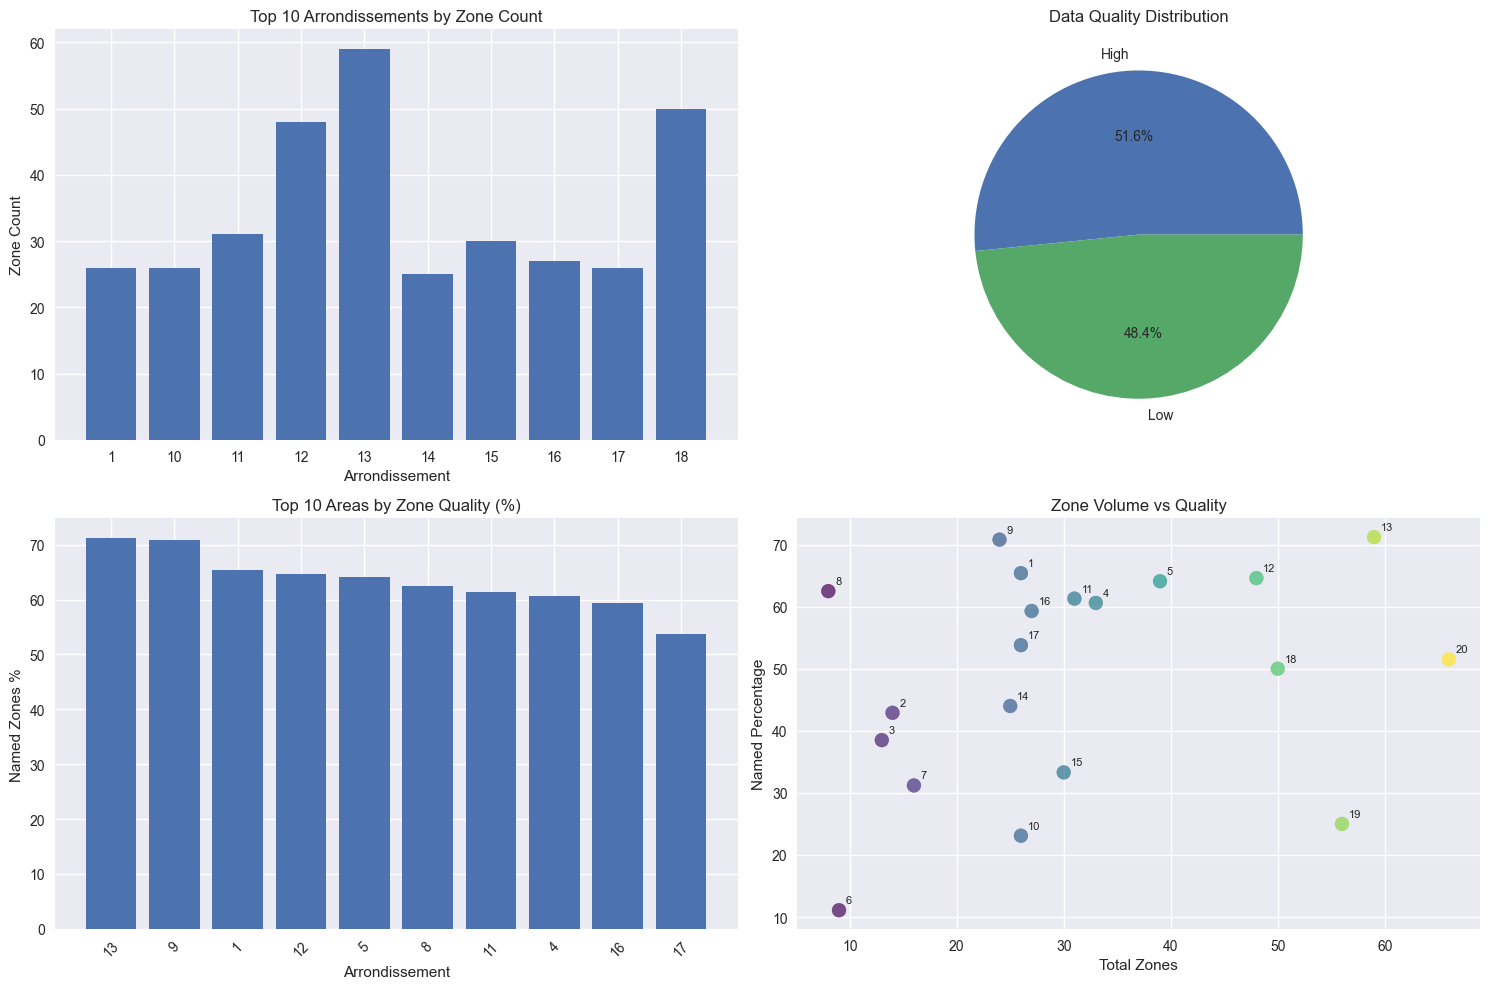

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Zones by arrondissement
top_10_arr = arr_distribution.head(10)
axes[0,0].bar(top_10_arr['arrondissement'], top_10_arr['zone_count'])
axes[0,0].set_title('Top 10 Arrondissements by Zone Count')
axes[0,0].set_xlabel('Arrondissement')
axes[0,0].set_ylabel('Zone Count')

# 2. Data quality distribution
quality_counts = pedestrian_data['data_quality'].value_counts()
axes[0,1].pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%')
axes[0,1].set_title('Data Quality Distribution')

# 3. Named percentage by arrondissement (top areas)
top_quality_arr = zone_analysis.nlargest(10, 'named_percentage')
axes[1,0].bar(top_quality_arr['arrondissement_clean'], top_quality_arr['named_percentage'])
axes[1,0].set_title('Top 10 Areas by Zone Quality (%)')
axes[1,0].set_xlabel('Arrondissement')
axes[1,0].set_ylabel('Named Zones %')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Zone volume vs quality scatter
axes[1,1].scatter(zone_analysis['total_zones'], zone_analysis['named_percentage'], 
                 s=100, alpha=0.7, c=zone_analysis['total_zones'], cmap='viridis')
axes[1,1].set_title('Zone Volume vs Quality')
axes[1,1].set_xlabel('Total Zones')
axes[1,1].set_ylabel('Named Percentage')

# Add arrondissement labels to scatter plot
for _, row in zone_analysis.iterrows():
    axes[1,1].annotate(row['arrondissement_clean'], 
                      (row['total_zones'], row['named_percentage']),
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

In [12]:

map_data = pedestrian_data.sample(min(300, len(pedestrian_data)))

map_data['zone_display'] = map_data.apply(lambda x: 
    x['zone_name'] if x['is_named'] else f"Unnamed Zone (Arr. {x['arrondissement_clean']})", axis=1)

map_data['zone_size'] = map_data['is_named'].astype(int) * 10 + 5  

fig = px.scatter_mapbox(
    map_data,
    lat='latitude',
    lon='longitude',
    color='data_quality',
    size='zone_size',
    hover_data={
        'zone_display': True,
        'arrondissement_clean': True,
        'data_quality': True
    },
    color_discrete_map={
        'High': '#FF4B4B',
        'Low': '#90EE90'
    },
    title='Pedestrian Zones Distribution Across Paris',
    zoom=11,
    height=600
)

fig.update_layout(mapbox_style="open-street-map")
fig.show()

print(f"Map showing {len(map_data)} zones")
print("Red: High quality (named zones)")
print("Green: Low quality (unnamed zones)")
print("Size: Larger dots = named zones")

Map showing 300 zones
Red: High quality (named zones)
Green: Low quality (unnamed zones)
Size: Larger dots = named zones


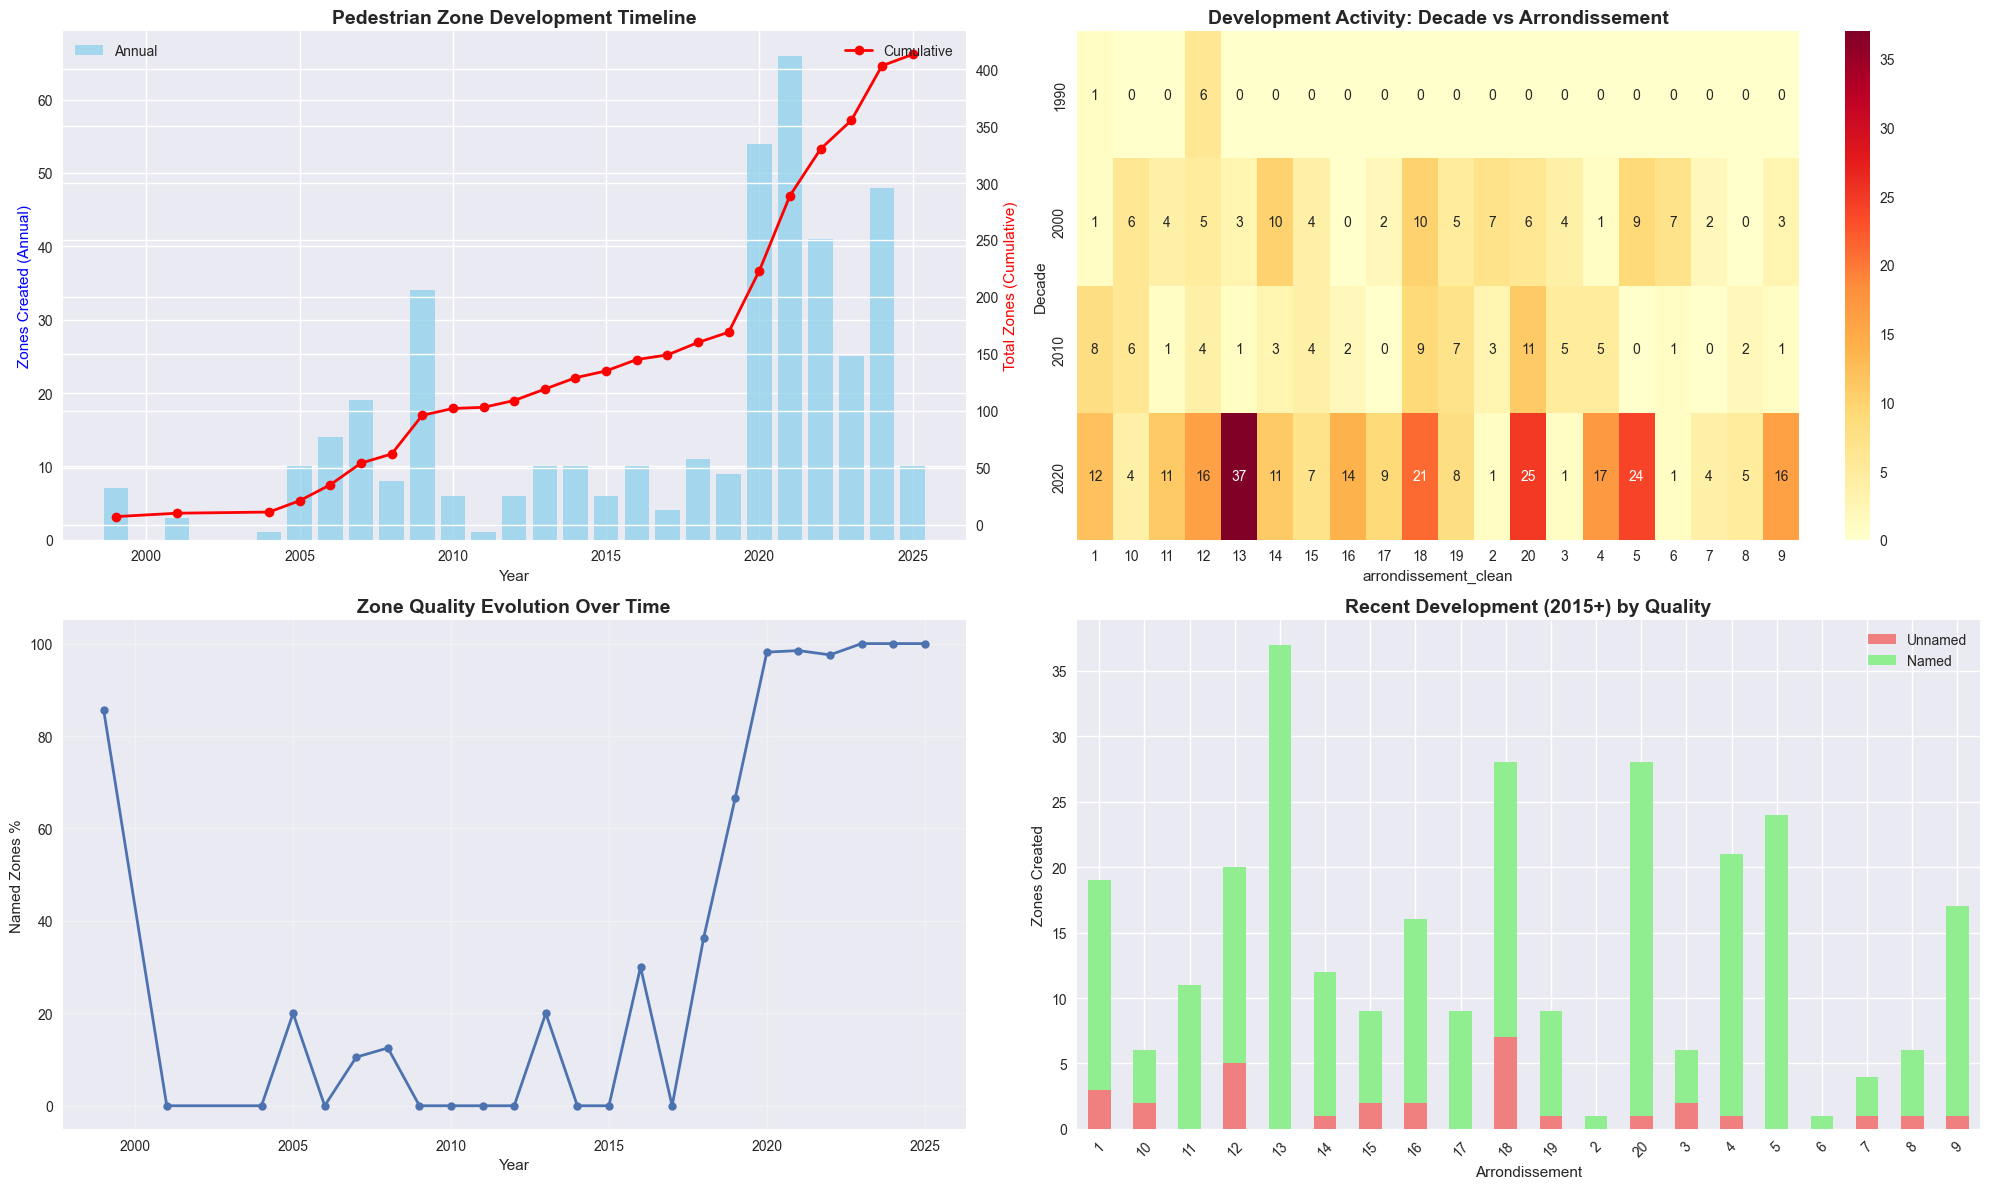

In [13]:
# Advanced temporal analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Timeline of zone establishment
if len(zones_with_dates) > 0:
    yearly_cumulative = yearly_establishment.copy()
    yearly_cumulative['cumulative_zones'] = yearly_cumulative['zones_created'].cumsum()
    
    # Dual axis plot
    ax1 = axes[0,0]
    ax2 = ax1.twinx()
    
    bars = ax1.bar(yearly_cumulative['establishment_year'], yearly_cumulative['zones_created'], 
                   alpha=0.7, color='skyblue', label='Annual')
    line = ax2.plot(yearly_cumulative['establishment_year'], yearly_cumulative['cumulative_zones'], 
                    color='red', marker='o', linewidth=2, label='Cumulative')
    
    ax1.set_title('Pedestrian Zone Development Timeline', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Zones Created (Annual)', color='blue')
    ax2.set_ylabel('Total Zones (Cumulative)', color='red')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# 2. Development intensity heatmap by decade and arrondissement
if len(zones_with_dates) > 0:
    zones_with_dates['decade'] = (zones_with_dates['establishment_year'] // 10) * 10
    decade_arr_heatmap = zones_with_dates.groupby(['decade', 'arrondissement_clean']).size().unstack(fill_value=0)
    
    sns.heatmap(decade_arr_heatmap, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0,1])
    axes[0,1].set_title('Development Activity: Decade vs Arrondissement', fontweight='bold', fontsize=14)
    axes[0,1].set_ylabel('Decade')

# 3. Zone quality evolution over time
if len(zones_with_dates) > 0:
    quality_timeline = zones_with_dates.groupby('establishment_year').agg({
        'is_named': ['sum', 'count']
    })
    quality_timeline.columns = ['named_zones', 'total_zones']
    quality_timeline['named_percentage'] = (quality_timeline['named_zones'] / quality_timeline['total_zones'] * 100)
    
    axes[1,0].plot(quality_timeline.index, quality_timeline['named_percentage'], 
                   marker='o', linewidth=2, markersize=6)
    axes[1,0].set_title('Zone Quality Evolution Over Time', fontweight='bold', fontsize=14)
    axes[1,0].set_xlabel('Year')
    axes[1,0].set_ylabel('Named Zones %')
    axes[1,0].grid(True, alpha=0.3)

# 4. Recent development focus (2015+)
recent_dev = zones_with_dates[zones_with_dates['establishment_year'] >= 2015]
if len(recent_dev) > 0:
    recent_by_arr = recent_dev.groupby(['arrondissement_clean', 'is_named']).size().unstack(fill_value=0)
    recent_by_arr.plot(kind='bar', stacked=True, ax=axes[1,1], color=['lightcoral', 'lightgreen'])
    axes[1,1].set_title('Recent Development (2015+) by Quality', fontweight='bold', fontsize=14)
    axes[1,1].set_xlabel('Arrondissement')
    axes[1,1].set_ylabel('Zones Created')
    axes[1,1].legend(['Unnamed', 'Named'])
    axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

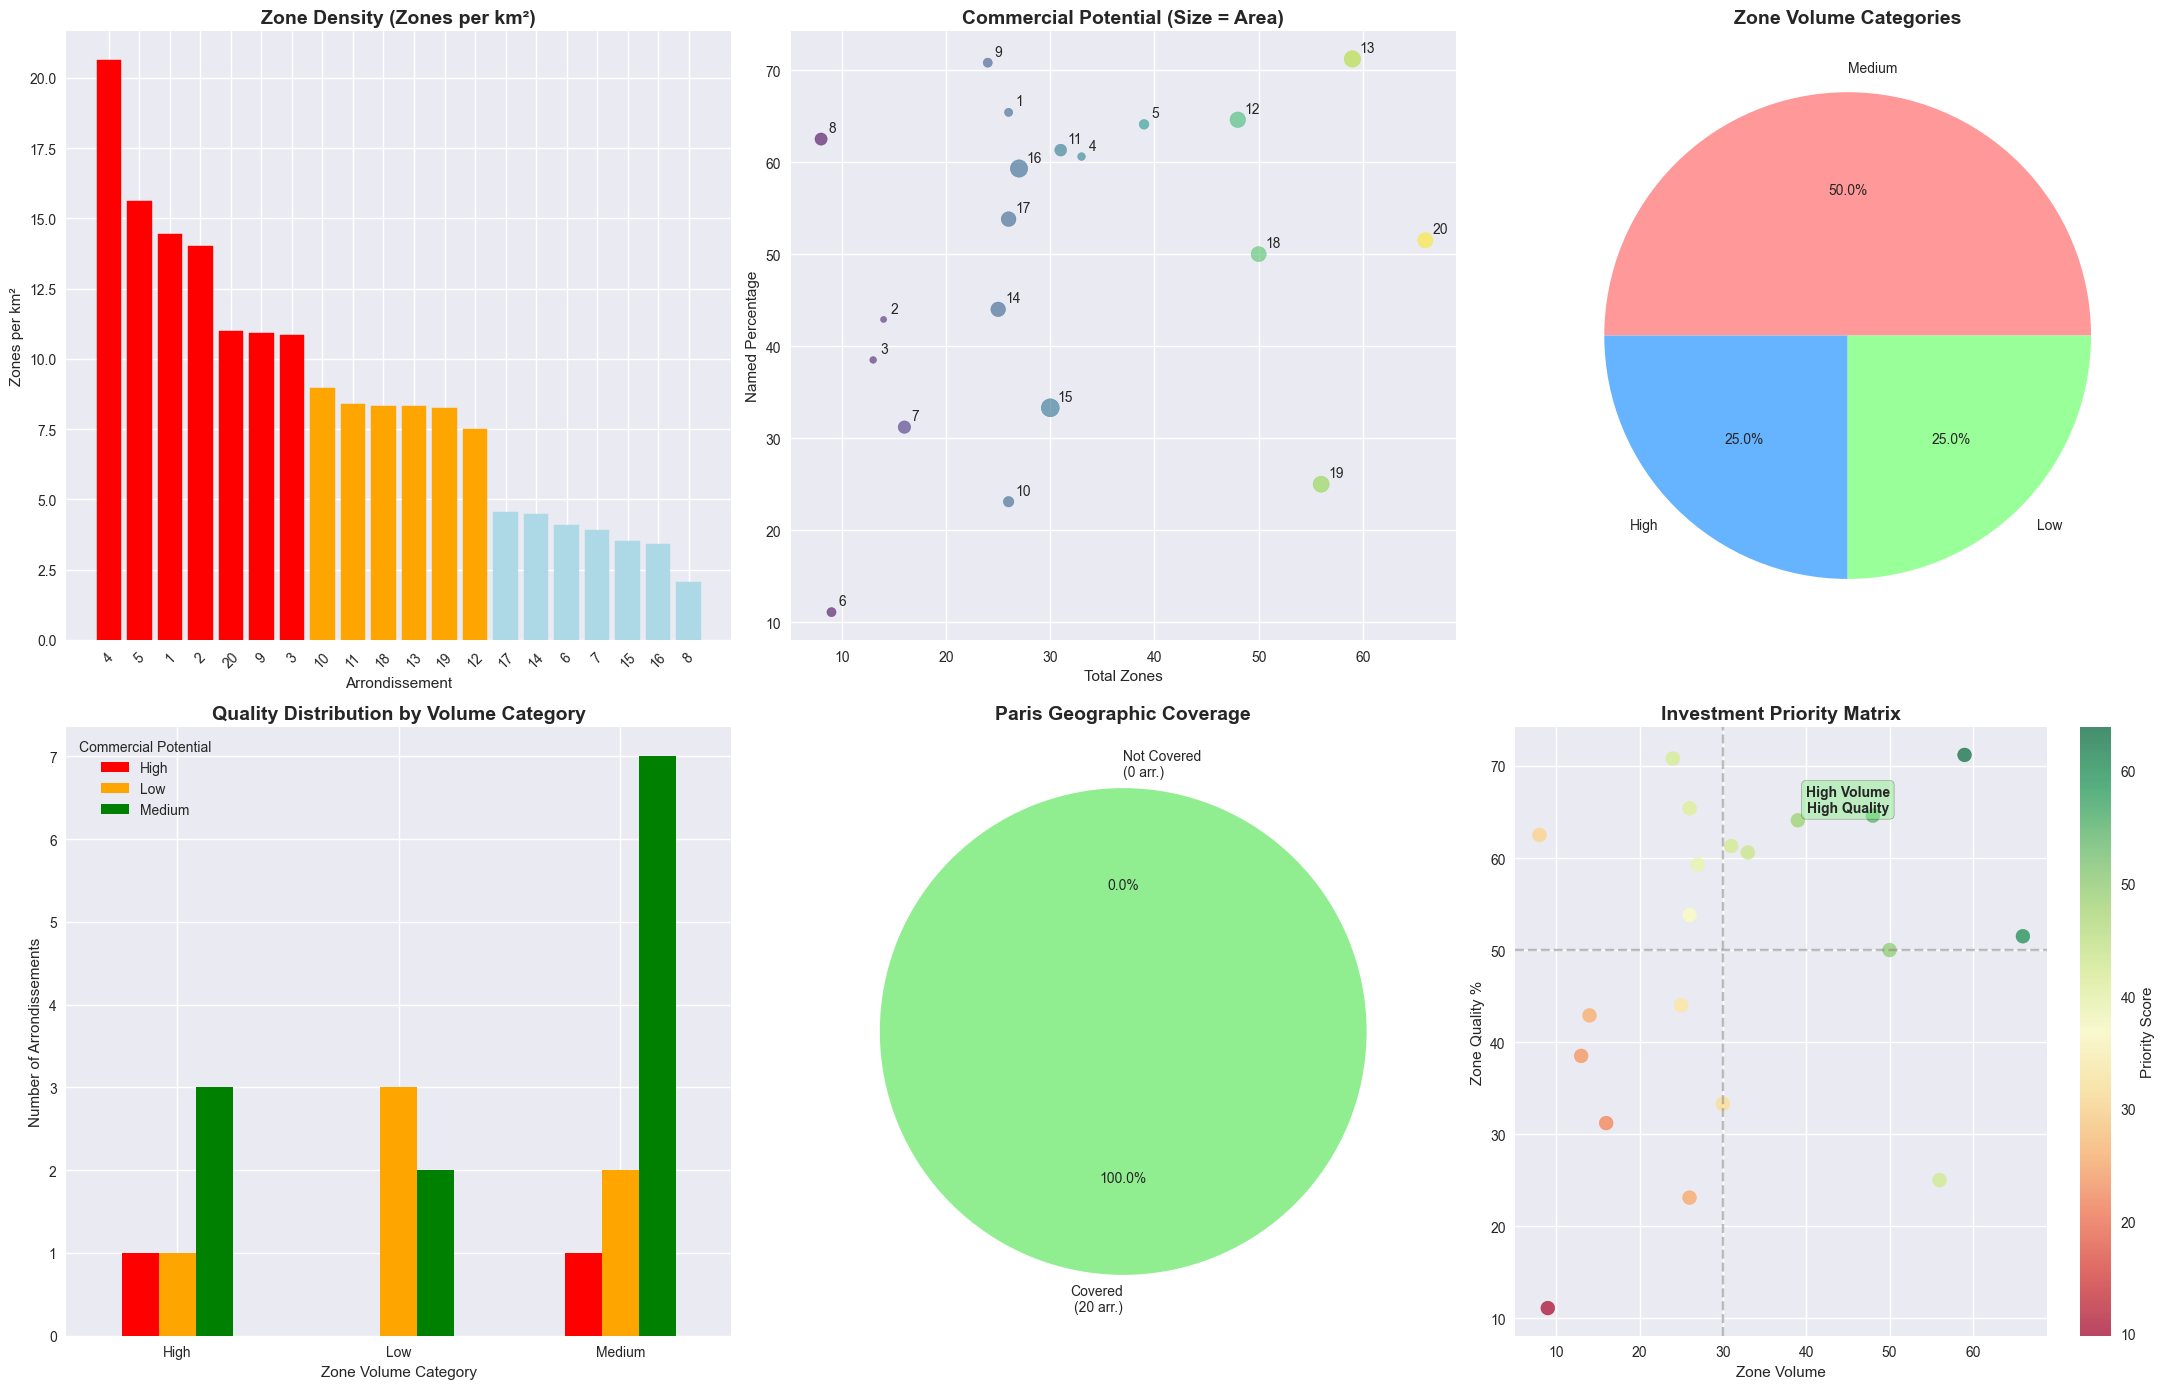

In [14]:
# Advanced geographic analysis
fig, axes = plt.subplots(2, 3, figsize=(22, 14))

# 1. Zone density by arrondissement (zones per km²)
# Approximate area data for Paris arrondissements (km²)
arr_areas = {
    '1': 1.8, '2': 1.0, '3': 1.2, '4': 1.6, '5': 2.5, '6': 2.2, '7': 4.1, '8': 3.9, '9': 2.2, '10': 2.9,
    '11': 3.7, '12': 6.4, '13': 7.1, '14': 5.6, '15': 8.5, '16': 7.9, '17': 5.7, '18': 6.0, '19': 6.8, '20': 6.0
}

zone_density = arr_distribution.copy()
zone_density['area_km2'] = zone_density['arrondissement'].map(arr_areas)
zone_density['density'] = zone_density['zone_count'] / zone_density['area_km2']
zone_density = zone_density.sort_values('density', ascending=False)

bars = axes[0,0].bar(zone_density['arrondissement'], zone_density['density'])
axes[0,0].set_title('Zone Density (Zones per km²)', fontweight='bold', fontsize=14)
axes[0,0].set_xlabel('Arrondissement')
axes[0,0].set_ylabel('Zones per km²')
axes[0,0].tick_params(axis='x', rotation=45)

# Color bars by density level
for i, bar in enumerate(bars):
    if zone_density.iloc[i]['density'] > 10:
        bar.set_color('red')
    elif zone_density.iloc[i]['density'] > 5:
        bar.set_color('orange')
    else:
        bar.set_color('lightblue')

# 2. Commercial potential vs geographic size
axes[0,1].scatter(zone_analysis['total_zones'], zone_analysis['named_percentage'], 
                 s=[arr_areas.get(arr, 5)*20 for arr in zone_analysis['arrondissement_clean']], 
                 alpha=0.6, c=zone_analysis['total_zones'], cmap='viridis')
axes[0,1].set_title('Commercial Potential (Size = Area)', fontweight='bold', fontsize=14)
axes[0,1].set_xlabel('Total Zones')
axes[0,1].set_ylabel('Named Percentage')

# Add arrondissement labels
for _, row in zone_analysis.iterrows():
    axes[0,1].annotate(row['arrondissement_clean'], 
                      (row['total_zones'], row['named_percentage']),
                      xytext=(5, 5), textcoords='offset points', fontsize=10)

# 3. Zone distribution patterns
zone_analysis['zone_category'] = 'Low'
zone_analysis.loc[zone_analysis['total_zones'] >= 40, 'zone_category'] = 'High'
zone_analysis.loc[(zone_analysis['total_zones'] >= 20) & (zone_analysis['total_zones'] < 40), 'zone_category'] = 'Medium'

category_counts = zone_analysis['zone_category'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']
axes[0,2].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', colors=colors)
axes[0,2].set_title('Zone Volume Categories', fontweight='bold', fontsize=14)

# 4. Quality distribution by zone category
quality_by_category = zone_analysis.groupby(['zone_category', 'commercial_potential']).size().unstack(fill_value=0)
quality_by_category.plot(kind='bar', ax=axes[1,0], color=['red', 'orange', 'green'])
axes[1,0].set_title('Quality Distribution by Volume Category', fontweight='bold', fontsize=14)
axes[1,0].set_xlabel('Zone Volume Category')
axes[1,0].set_ylabel('Number of Arrondissements')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].legend(title='Commercial Potential')

# 5. Geographic coverage analysis
paris_total = 20
covered = len(zone_analysis)
coverage_data = [covered, paris_total - covered]
coverage_labels = [f'Covered\n({covered} arr.)', f'Not Covered\n({paris_total - covered} arr.)']

wedges, texts, autotexts = axes[1,1].pie(coverage_data, labels=coverage_labels, autopct='%1.1f%%', 
                                        colors=['lightgreen', 'lightcoral'], startangle=90)
axes[1,1].set_title('Paris Geographic Coverage', fontweight='bold', fontsize=14)

# 6. Investment priority matrix
investment_matrix = zone_analysis.copy()
investment_matrix['priority_score'] = (investment_matrix['total_zones'] * 0.6 + 
                                     investment_matrix['named_percentage'] * 0.4)

scatter = axes[1,2].scatter(investment_matrix['total_zones'], investment_matrix['named_percentage'],
                           s=100, c=investment_matrix['priority_score'], cmap='RdYlGn', alpha=0.7)
axes[1,2].set_title('Investment Priority Matrix', fontweight='bold', fontsize=14)
axes[1,2].set_xlabel('Zone Volume')
axes[1,2].set_ylabel('Zone Quality %')

# Add priority quadrants
axes[1,2].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
axes[1,2].axvline(x=30, color='gray', linestyle='--', alpha=0.5)
axes[1,2].text(45, 65, 'High Volume\nHigh Quality', ha='center', fontweight='bold', 
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.colorbar(scatter, ax=axes[1,2], label='Priority Score')
plt.tight_layout()
plt.show()

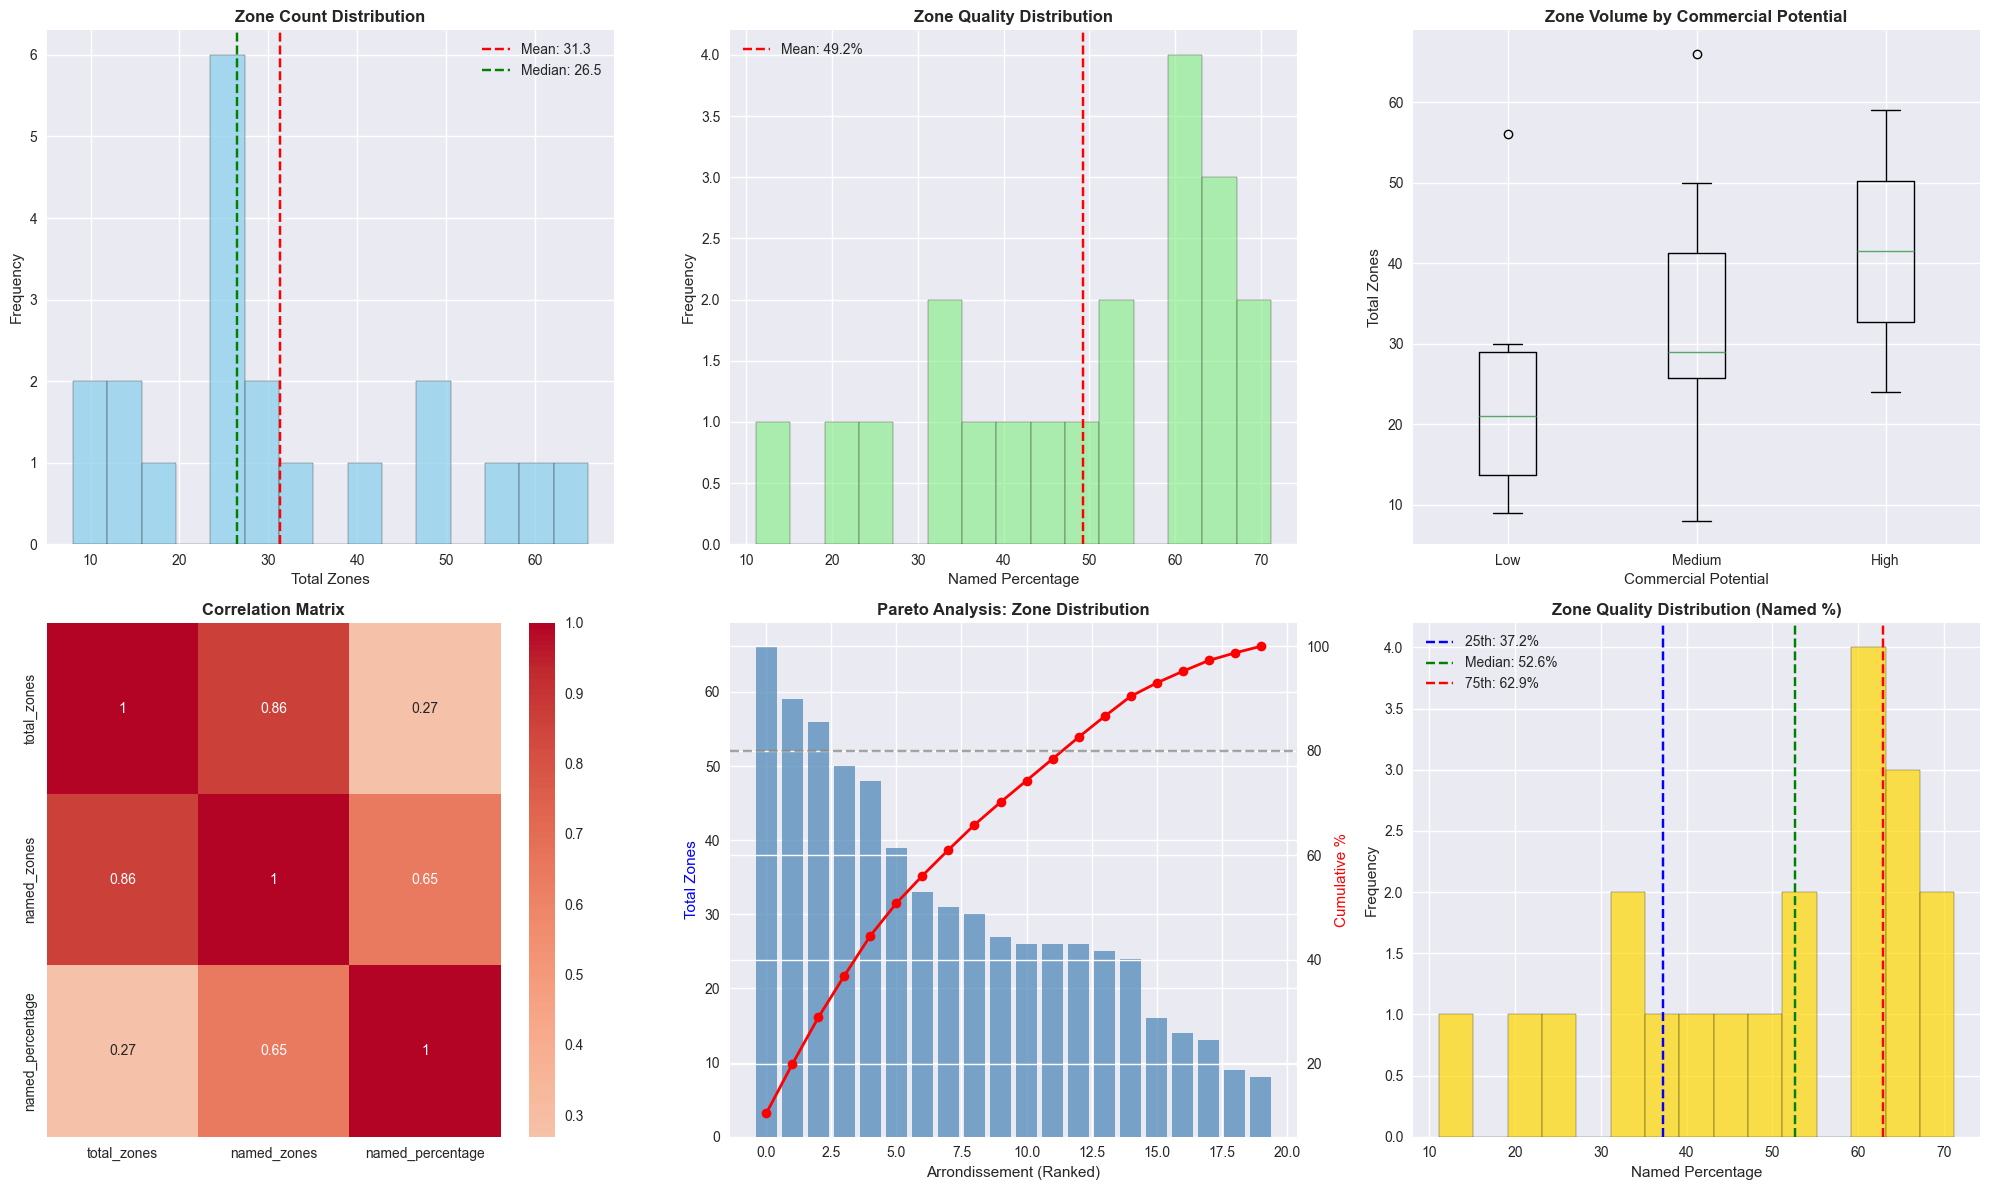

In [15]:
# Advanced statistical visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Distribution analysis
axes[0,0].hist(zone_analysis['total_zones'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(zone_analysis['total_zones'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {zone_analysis["total_zones"].mean():.1f}')
axes[0,0].axvline(zone_analysis['total_zones'].median(), color='green', linestyle='--', 
                 label=f'Median: {zone_analysis["total_zones"].median():.1f}')
axes[0,0].set_title('Zone Count Distribution', fontweight='bold')
axes[0,0].set_xlabel('Total Zones')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 2. Quality distribution
axes[0,1].hist(zone_analysis['named_percentage'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(zone_analysis['named_percentage'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {zone_analysis["named_percentage"].mean():.1f}%')
axes[0,1].set_title('Zone Quality Distribution', fontweight='bold')
axes[0,1].set_xlabel('Named Percentage')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# 3. Box plot by commercial potential
commercial_groups = [zone_analysis[zone_analysis['commercial_potential'] == level]['total_zones'] 
                    for level in ['Low', 'Medium', 'High']]
axes[0,2].boxplot(commercial_groups, labels=['Low', 'Medium', 'High'])
axes[0,2].set_title('Zone Volume by Commercial Potential', fontweight='bold')
axes[0,2].set_xlabel('Commercial Potential')
axes[0,2].set_ylabel('Total Zones')

# 4. Correlation matrix
correlation_data = zone_analysis[['total_zones', 'named_zones', 'named_percentage']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
axes[1,0].set_title('Correlation Matrix', fontweight='bold')

# 5. Pareto analysis (80/20 rule)
sorted_zones = zone_analysis.sort_values('total_zones', ascending=False)
sorted_zones['cumulative_zones'] = sorted_zones['total_zones'].cumsum()
sorted_zones['cumulative_percentage'] = (sorted_zones['cumulative_zones'] / sorted_zones['total_zones'].sum() * 100)

ax1 = axes[1,1]
ax2 = ax1.twinx()

bars = ax1.bar(range(len(sorted_zones)), sorted_zones['total_zones'], alpha=0.7, color='steelblue')
line = ax2.plot(range(len(sorted_zones)), sorted_zones['cumulative_percentage'], 
                color='red', marker='o', linewidth=2)

ax1.set_title('Pareto Analysis: Zone Distribution', fontweight='bold')
ax1.set_xlabel('Arrondissement (Ranked)')
ax1.set_ylabel('Total Zones', color='blue')
ax2.set_ylabel('Cumulative %', color='red')
ax2.axhline(y=80, color='gray', linestyle='--', alpha=0.7)

# 6. Commercial score distribution using named_percentage as proxy
axes[1,2].hist(zone_analysis['named_percentage'], bins=15, alpha=0.7, color='gold', edgecolor='black')

# Add percentile lines for named_percentage
p25 = zone_analysis['named_percentage'].quantile(0.25)
p75 = zone_analysis['named_percentage'].quantile(0.75)
median = zone_analysis['named_percentage'].median()

axes[1,2].axvline(p25, color='blue', linestyle='--', label=f'25th: {p25:.1f}%')
axes[1,2].axvline(median, color='green', linestyle='--', label=f'Median: {median:.1f}%')
axes[1,2].axvline(p75, color='red', linestyle='--', label=f'75th: {p75:.1f}%')

axes[1,2].set_title('Zone Quality Distribution (Named %)', fontweight='bold')
axes[1,2].set_xlabel('Named Percentage')
axes[1,2].set_ylabel('Frequency')
axes[1,2].legend()

plt.tight_layout()
plt.show()

In [17]:
# Export processed datasets
pedestrian_data.to_csv('../data/processed/pedestrian_zones_processed.csv', index=False)

print("\nPedestrian zones analysis complete!")


Pedestrian zones analysis complete!
